In [294]:
initK=-1.1
increments=[]
for i in range(21):
    initK=round(initK+0.1,1)
    increments.append(initK)
print(increments)

[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


[-1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2
 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2
  1.3  1.4  1.5]
0.894427190999916


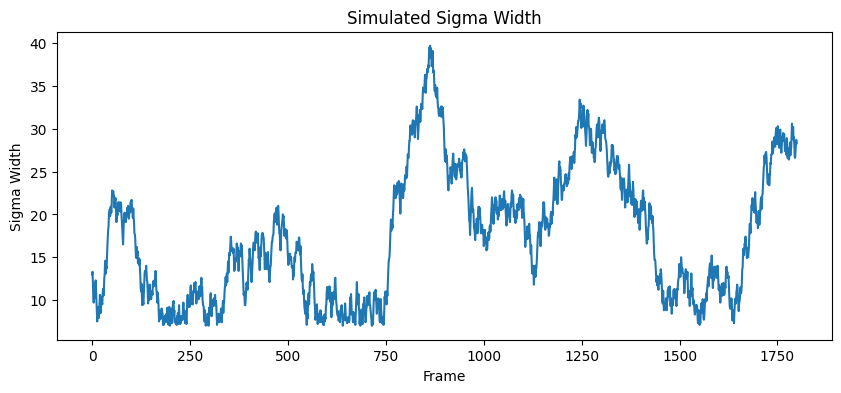

In [46]:
from matplotlib import pyplot as plt
import numpy as np

expectedFrameRate = 60
toleranceTrialN = 600

def generateWalkofSigmaDifficulty(meanSigma=15, velocity_std=1, duration=20, minSigma=5, maxSigma=35):
    num_frames = int(duration * expectedFrameRate) + toleranceTrialN
    initK=-1.6
    increments=[]
    for i in range(31):
        initK=round(initK+0.1,1)
        increments.append(initK)
    increments = np.array(increments)

    #increments = np.linspace(-1, 1, 30)#np.array([-1, -0.75, -0.5, -0.1,0.1, 0.2,0.3,0.4,0.5 0.75, 1])
    #increments = np.linspace(-1, 1, 30)#np.array([-1, -0.75, -0.5, -0.1,0.1, 0.2,0.3,0.4,0.5 0.75, 1])
    #increments = np.array([-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    #increments=np.array([-1,1])
    print(increments)
    print(increments.std())
    sigma_width = np.zeros(num_frames)
    sigma_width[0] = meanSigma  # Start from the meanSigma

    for i in range(1, num_frames):
        # Filter increments to only those that do not push sigma_width out of bounds
        valid_increments = increments[(sigma_width[i-1] + increments >= minSigma) & (sigma_width[i-1] + increments <= maxSigma)]
        if valid_increments.size == 0:
            # If no valid increments, maintain current position
            sigma_width[i] = sigma_width[i-1]
        else:
            # Randomly choose from the valid increments
            sigma_width[i] = sigma_width[i-1] + np.random.choice(valid_increments)
    return sigma_width

# Generate data
allSigmaWalks = generateWalkofSigmaDifficulty(meanSigma=13, velocity_std=1, duration=20, minSigma=7, maxSigma=40)
plt.figure(figsize=(10, 4))
plt.plot(allSigmaWalks)
plt.title('Simulated Sigma Width')
plt.xlabel('Frame')
plt.ylabel('Sigma Width')
plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as sio
import glob


In [2]:
only_mouse = False
def load_and_process_data(directory_path, part_of_file_name):
    # get latest file from data folder that includes part_of_file_name in its name
    fileIs = sorted((f for f in glob.glob(f"{directory_path}/*") if part_of_file_name in f), key=os.path.getctime)[-1]

    # load the .mat file
    mat_contents = sio.loadmat(fileIs)
    # extract the necessary data
    if only_mouse:
        sigma, dynamicSigma, confRate,target = mat_contents['sigma'], mat_contents['dynamicSigma'], mat_contents['mouse_y'], mat_contents['blob_x']
        eyeResp = None
    else:
        sigma, dynamicSigma, confRate,target,eyeResp = mat_contents['sigma'], mat_contents['dynamicSigma'], mat_contents['mouse_y'], mat_contents['blob_x'], mat_contents['eyeX']

    mouseResp = mat_contents['mouse_x'] if fileIs.split('_')[2] == "both" else None
    if mouseResp is not None:
        mouseResp = mouseResp - np.mean(mouseResp, axis=1, keepdims=True)
    #eyeResp = eyeResp - np.mean(eyeResp, axis=1, keepdims=True)
    target = target - np.mean(target, axis=1, keepdims=True)
   
    # z score of the data
    from scipy.stats import zscore

    confRate = zscore(confRate, axis=1)
    dynamicSigma = zscore(dynamicSigma, axis=1)
    
   
    # calculate the number of trials
    nTrial = len(sigma.flatten())
    nSigma = (nTrial - 1) // 5 + 1
    nTrialPerSigma = nTrial // nSigma
    blob_widths = np.unique(sigma.flatten())
    sigma=np.array(list(list(np.repeat(39,5))+list(sigma[0][5:])))

    return fileIs,sigma, dynamicSigma, confRate,target,eyeResp, nTrial, nSigma, nTrialPerSigma, blob_widths,


fileIs,sigma, dynamicSigma, confRate,target,eyeResp = load_and_process_data("data", "p4")[:6]
# delete sigma 16
blob_widths = np.unique(sigma)
# calculate the number of trials
nTrial = len(sigma.flatten())
nSigma = (nTrial - 1) // 5 + 1
nTrialPerSigma = nTrial // nSigma
print(nTrial, nSigma, nTrialPerSigma, blob_widths)

20 4 5 [ 7 15 23 39]


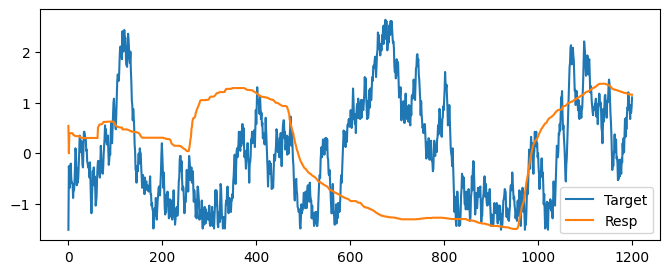

In [3]:
# plot the data
trialNum=5
plt.figure(figsize=(8,3))
plt.plot(dynamicSigma[trialNum,:])
plt.plot(confRate[trialNum,:])
plt.legend(['Target','Resp'])
plt.show()



In [4]:
from scipy.ndimage import gaussian_filter1d

def smooth_data(data_to_smooth, window_size=10):
    # Create a moving average filter
    filter = np.ones(window_size) / window_size
    # Apply the filter to the response data using list comprehension
    smoothed_response = [np.convolve(trial, filter, mode='same') for trial in data_to_smooth]
    return np.squeeze(smoothed_response)
#dynamicSigma = smooth_data(dynamicSigma)
#target = smooth_data(target)

In [41]:
response=confRate
# create key-value pairs for the dictionary of 30 trials
trial_dict = {}
for i in range(nTrial):
    trial_dict[i]={'target': dynamicSigma[i,60:], 'confResp': confRate[i,60:], 'sigma': sigma[i]} #my data
    if fileIs.split('_')[1]=="both":
        trial_dict[i]['eyeX']=eyeResp[i,60:]

# sort the dictionary by sigma
trialDictSorted = sorted(((k, v) for k, v in trial_dict.items()), key=lambda x: x[1]['sigma']) # x[1]['sigma'] gives the value of sigma for each trial and la
tmp_trial=trialDictSorted[0][1]

## Negative Log Likelihood Uncertainty Estimates

In [42]:
from scipy.sparse import diags
import scipy.optimize as opt
def negLogLikelihood(rr, Q, X, Xhat):
    numTrials = X.shape[1]  # number of trials
    N = X.shape[0]          # number of samples

    rr = np.exp(rr)  # exponentiate observation noise variance
    pp = Q / 2 * (np.sqrt(1 + 4 * rr / Q) - 1)  # posterior variance - Eq B8
    k = (pp + Q) / (pp + Q + rr)  # Kalman Gain - eq B10
    
    # Create a sparse matrix for D
    d = diags([np.ones(N), (k - 1) * np.ones(N)], [0, -1], shape=(N, N)).toarray()  # Eq B12

    # Compute nLL using list comprehension
    nLL = -sum(-1 / (2 * k**2 * rr) * np.dot((np.dot(d, Xhat[:, i]) - k * X[:, i]).T, np.dot(d, Xhat[:, i]) - k * X[:, i]) - N / 2 * np.log(rr) - N * np.log(k) for i in range(numTrials))

    return nLL
from scipy.optimize import minimize



In [5]:
import matplotlib.cm as cm
import numpy as np
# Get the 'viridis' colormap
cmap = cm.get_cmap('rainbow')
# Generate 10 evenly spaced values between 0 and 1
values = np.linspace(0, 1, 10)
# Get 10 colors from the colormap
colors = [cmap(value) for value in values]
colors = ['#000000', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#606060', '#804000', '#408080']

C:\Users\omeru\AppData\Local\Temp\ipykernel_4524\2822273860.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


In [6]:


def plot_uncertainty_estimates(dataType, numP, color):
    r_values = []
    fileIs,sigma, dynamicSigma, confRate,target,eyeResp = load_and_process_data("data", "p4")[:6]
    X = dynamicSigma
    Y = confRate#mouseResp if dataType == "data_both" else eyeResp
    nLLs = []
    r_values = np.zeros(len(blob_widths))
    fval_values = np.zeros(len(blob_widths))
    lag=12
    clip=60
    Xc = X[:, clip:X.shape[1] -lag] - np.mean(X[:, clip:X.shape[1]-lag], axis=1)[:, np.newaxis]
    Yc = Y[:, lag+clip:] - np.mean(Y[:, lag+clip:], axis=1)[:, np.newaxis]
    results=[]
    Q=1
    rr_initial_guess = np.log(100)
    sigmas = np.unique(sigma)[::-1]
    for i in range(len(sigmas)):
        index = [s == sigmas[i] for s in sigma]
        index=np.array(index).flatten()
        result = minimize(negLogLikelihood, rr_initial_guess, args=(Q, Xc[index,:].T, Yc[index,:].T), method='BFGS', options={'maxiter': 1000})
        results.append(result)
        r_values[i] = np.sqrt(result.x[0])
        fval_values[i] = result.fun
        print('For Sigma Value '+str(sigmas[i])+' Optimal value for observation noise variance is ' + str(r_values[i]))
        plt.semilogx(sigmas[i], r_values[i], 's' if dataType=="data_both" else '.', linewidth=3, markersize=13 if dataType=="data_both" else 15, label=f'sigma={sigmas}',color=color, alpha=0.7)

    plt.title('Confidence Uncertainty vs Blob Range')
    plt.plot(sigmas, r_values, 'k-',color=color)
    # # set x-axis labels as ["low", "medium", "high","fullscale"]    
    #plt.xticks(sigmas, ["low", "medium", "high","fullscale"].reverse())
    # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

    plt.xlabel('Blob Width (sigma)')
    plt.ylabel('Positional Uncertainty (sqrt(R))')
    return r_values

# Usage
randomColorCode = np.random.rand(3,)
r_values = plot_uncertainty_estimates("data", 0, randomColorCode)

NameError: name 'minimize' is not defined

In [ ]:
rValBoth_all = []
rValEye_all = []
for numP in range(10):
    randomColorCode = np.random.rand(3,)
    for dataType in ["data_eye", "data_both"]:
        r_values_eye = []
        r_values_both = []
        sigma, eyeResp, target, mouseResp = load_and_process_data(dataType, 'p'+str(numP))[:4]
        print(numP)
        X = target
        if dataType == "data_both":
            Y = mouseResp
        else:
            Y = eyeResp
            #Y = smooth_data(Y)
        nLLs = []
        i=0
        # Initialize arrays to store results
        r_values = np.zeros(len(blob_widths))
        fval_values = np.zeros(len(blob_widths))
        # Plot setup
        lag=12
        clip=60

        Xc = X[:, clip:X.shape[1] -lag] - np.mean(X[:, clip:X.shape[1]-lag], axis=1)[:, np.newaxis]
        Yc = Y[:, lag+clip:] - np.mean(Y[:, lag+clip:], axis=1)[:, np.newaxis]
        results=[]
        Q=1
        # calculate intirial Guess for Q 
        rr_initial_guess = np.log(100)  # Initial guess for log observation noise variance
        # sigmas is reversed unique values of sigma
        sigmas = np.unique(sigma)[::-1]
        for i in range(len(sigmas)):
            index = [s == sigmas[i] for s in sigma]
            index=np.array(index).flatten()
            #calculate Q for each sigma as a variance of displacement
            result = minimize(negLogLikelihood, rr_initial_guess, args=(Q, Xc[index,:].T, Yc[index,:].T), method='BFGS', options={'maxiter': 1000})
            results.append(result)
            # # Store optimization results
            r_values[i] = np.sqrt(result.x[0])
            fval_values[i] = result.fun
            print('Optimal value for observation noise variance is ' + str(r_values[i]))
            # # Plot the result
            if dataType=="data_both":    
                plt.semilogx(sigmas[i], r_values[i], 's', linewidth=3, markersize=13, label=f'sigma={sigmas}',color=colors[numP], alpha=0.7)
                #r_values_both.append(r_values)

            else:
                plt.semilogx(sigmas[i], r_values[i], '.', linewidth=3, markersize=15, label=f'sigma={sigmas}',color=colors[numP], alpha=0.7)
                #r_values_eye.append(r_values)
        plt.plot(sigmas, r_values, 'k-',color=colors[numP])
        if dataType=="data_both":
            rValBoth_all.append(r_values)
        else:
            rValEye_all.append(r_values)

plt.xlabel('Blob Width (sigma)')
plt.ylabel('Positional Uncertainty (sqrt(R))')

KeyError: 'dynamicSigma'

In [ ]:
flattned_rValBoth_all = [item for sublist in rValBoth_all for item in sublist]
flattned_rValEye_all = [item for sublist in rValEye_all for item in sublist]

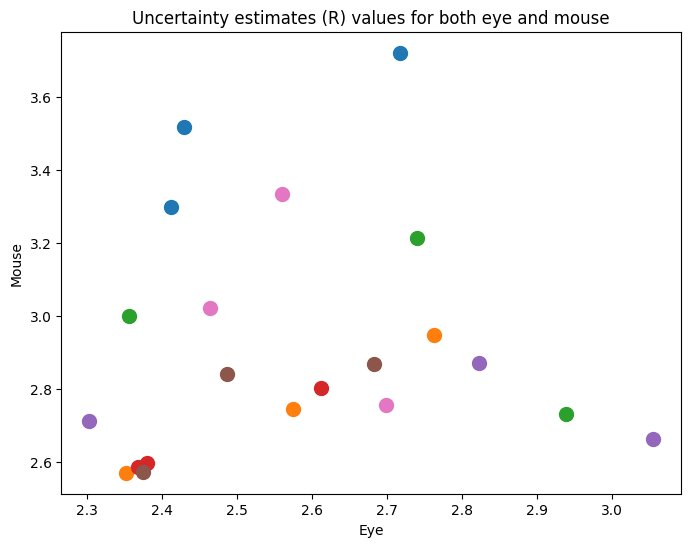

In [12]:
rValBoth_all = np.array(rValBoth_all)
rValEye_all = np.array(rValEye_all)
# Plot R values for both eye and mouse
plt.figure(figsize=(8, 6))
plt.plot(rValBoth_all.T,rValEye_all.T, 'o', markersize=10)
plt.xlabel('Eye')
plt.ylabel('Mouse')
plt.title('Uncertainty estimates (R) values for both eye and mouse')
plt.show()


In [2]:
import numpy as np

# Define the matrix with NaN where indicated
matrix = np.array([
    [10, np.nan, 12,np.nan,np.nan,np.nan],
    [np.nan, 11, np.nan,np.nan,np.nan,15],
])

# Compute the average of each column, ignoring NaN values
average = np.nanmean(matrix, axis=0)
average


C:\Users\omeru\AppData\Local\Temp\ipykernel_12016\366569788.py:10: RuntimeWarning: Mean of empty slice
  average = np.nanmean(matrix, axis=0)


array([10., 11., 12., nan, nan, 15.])

In [41]:
# Create a sample 90x3 matrix filled with random numbers for demonstration
np.random.seed(0)  # Seed for reproducibility
12
large_matrix = np.random.rand(90, 12) * 100  # 90 rows and 3 columns with values scaled to 0-100

# Set half of the values to NaN to simulate missing data
large_matrix[large_matrix > 50] = np.nan
large_matrix[2,0]=10000
print(large_matrix)

[[           nan            nan            nan ... 3.83441519e+01
             nan            nan]
 [           nan            nan 7.10360582e+00 ...            nan
  4.61479362e+01            nan]
 [1.00000000e+04            nan 1.43353287e+01 ...            nan
  1.87898004e+00            nan]
 ...
 [2.42727046e+00 4.30115984e+01            nan ... 2.56113795e+01
             nan 2.32772672e+01]
 [3.10629218e+01            nan            nan ... 8.32909797e+00
  5.10754802e+00            nan]
 [           nan 1.52027227e+01 6.64218590e-02 ...            nan
             nan            nan]]


In [42]:

# Reshape the matrix to group every three rows (now 30x3x3)
reshaped_matrix = large_matrix.reshape(30, 3, 12)
print(reshaped_matrix)


[[[           nan            nan            nan ... 3.83441519e+01
              nan            nan]
  [           nan            nan 7.10360582e+00 ...            nan
   4.61479362e+01            nan]
  [1.00000000e+04            nan 1.43353287e+01 ...            nan
   1.87898004e+00            nan]]

 [[           nan            nan            nan ...            nan
   2.10382561e+01 1.28926298e+01]
  [3.15428351e+01 3.63710771e+01            nan ... 2.53291603e+01
   4.66310773e+01 2.44425592e+01]
  [1.58969584e+01 1.10375141e+01            nan ... 9.60984079e+00
              nan 4.68651202e+01]]

 [[           nan            nan            nan ... 4.14262995e+01
   6.41474963e+00            nan]
  [           nan 2.65389491e+01            nan ...            nan
   2.89406093e+01 1.83191362e+01]
  [           nan 2.01075462e+00            nan ...            nan
              nan            nan]]

 ...

 [[           nan            nan            nan ...            nan
            

In [43]:

# Compute the mean across the new middle axis (axis=1), which corresponds to the three grouped rows
means = np.nanmean(reshaped_matrix, axis=1)
means.shape, means  # Show shape to confirm and some of the resulting means


C:\Users\omeru\AppData\Local\Temp\ipykernel_12016\3370016712.py:2: RuntimeWarning: Mean of empty slice
  means = np.nanmean(reshaped_matrix, axis=1)


((30, 12),
 array([[1.00000000e+04,            nan, 1.07194673e+01, 8.71292997e+00,
         2.21936598e+01, 4.14661940e+01, 3.51071412e+01,            nan,
         4.56150332e+01, 3.83441519e+01, 2.40134581e+01,            nan],
        [2.37198967e+01, 2.37042956e+01,            nan, 2.88392232e+01,
         2.78045131e+01, 3.02600645e+01, 2.08876756e+01, 1.06212088e+01,
                    nan, 1.74695005e+01, 3.38346667e+01, 2.80667697e+01],
        [           nan, 1.42748519e+01,            nan, 4.59412597e+00,
         2.82806963e+01, 1.95102267e+01, 3.07354575e+01, 1.18727719e+01,
         2.32844728e+01, 4.14262995e+01, 1.76776795e+01, 1.83191362e+01],
        [1.79277848e+01, 2.98282326e+01, 4.47125379e+01,            nan,
         4.23855049e+01, 2.97436951e+01, 1.91931983e+00, 3.76499664e+01,
                    nan, 3.28819739e+01, 4.35864925e+01, 4.28768701e+01],
        [           nan, 1.71629677e+01, 2.53705092e+01, 6.17524919e+00,
         1.99996525e+01, 2.36032239e

0.0006944444444444445


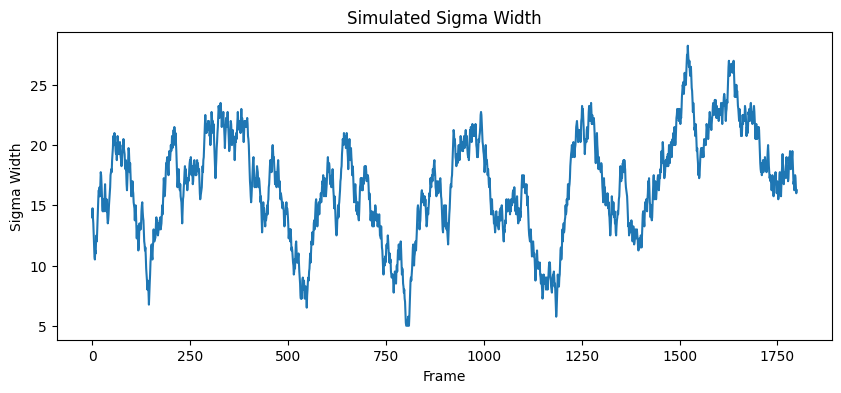

In [250]:
expectedFrameRate=60
toleranceTrialN=600

from matplotlib import pyplot as plt

def generateWalkofSigmaDifficulty(meanSigma=15, velocity_std=1, duration=20,minSigma=10,maxSigma=30):
    # Generate random velocity for each fram
    num_frames = int(duration * expectedFrameRate)+toleranceTrialN # add 600 frames to the duration	
    # Define the discrete increments
    increments = np.array([-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1])
    # Generate random choices from the increments array
    velocies_x = np.random.choice(increments, num_frames)
    #velocies_x=np.random.normal(0, velocity_std, num_frames)
    print(velocies_x.mean())
    # new positions = old position + velocity
    sigma_width = np.cumsum(velocies_x)
    sigma_width = sigma_width  + meanSigma
    # clip positions to stay within the field
    sigma_width = np.clip(sigma_width, minSigma, maxSigma) 
    return sigma_width


allSigmaWalks = generateWalkofSigmaDifficulty(meanSigma=15, velocity_std=.001, duration=20,minSigma=5,maxSigma=35)

allSigmaWalks[0:1000]
plt.figure(figsize=(10, 4))
plt.plot(allSigmaWalks)
plt.title('Simulated Sigma Width')
plt.xlabel('Frame')
plt.ylabel('Sigma Width')
plt.show()



0.6454972243679028
15.749444444444444


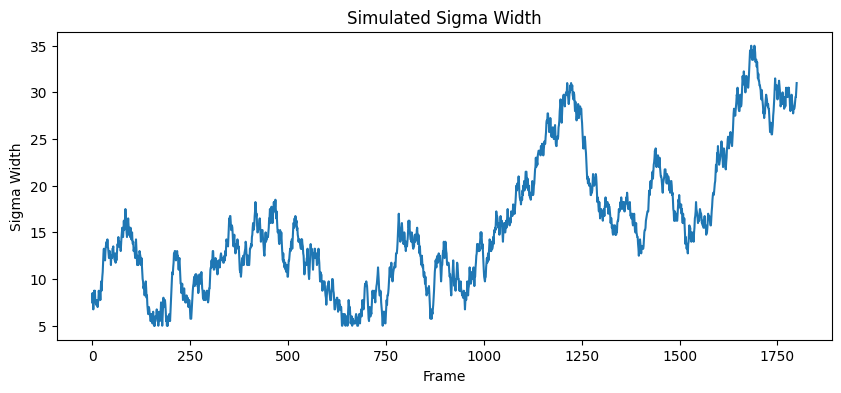

In [22]:
from matplotlib import pyplot as plt
import numpy as np

expectedFrameRate = 60
toleranceTrialN = 600

def generateWalkofSigmaDifficulty(meanSigma=15, velocity_std=1, duration=20, minSigma=5, maxSigma=35):
    num_frames = int(duration * expectedFrameRate) + toleranceTrialN
    increments = np.array([-1, -0.75, -0.5, -0.25, 0,0.25, 0.5, 0.75, 1])
    print(increments.std())
    sigma_width = np.zeros(num_frames)
    sigma_width[0] = meanSigma  # Start from the meanSigma

    for i in range(1, num_frames):
        # Filter increments to only those that do not push sigma_width out of bounds
        valid_increments = increments[(sigma_width[i-1] + increments >= minSigma) & (sigma_width[i-1] + increments <= maxSigma)]
        if valid_increments.size == 0:
            # If no valid increments, maintain current position
            sigma_width[i] = sigma_width[i-1]
        else:
            # Randomly choose from the valid increments
            sigma_width[i] = sigma_width[i-1] + np.random.choice(valid_increments)
    return sigma_width

# Generate data
allSigmaWalks = generateWalkofSigmaDifficulty(meanSigma=7.5, velocity_std=1, duration=20, minSigma=5, maxSigma=35)
print(allSigmaWalks.mean())
# Plot the first 1000 data points
plt.figure(figsize=(10, 4))
plt.plot(allSigmaWalks)
plt.title('Simulated Sigma Width')
plt.xlabel('Frame')
plt.ylabel('Sigma Width')
plt.show()
